# Modelo predictivo para la producción cafetera

Este proyecto tiene como objetivo implementar una herramienta automatizada para predecir la cosecha de café en un intervalo de fechas dado a partir de imágenes de cafetos mediante técnicas de aprendizaje profundo. La necesidad surge en el contexto de la industria cafetera, donde una predicción precisa de las cosechas futuras es crucial para la planificación de la cosecha, la logística y la negociación de contratos de exportación, que son en su mayoria de venta a futuro.

El modelo desarrollado apunta reemplazar métodos tradicionales de muestreo manual, que resultan costosas y tediosas, por un sistema que analiza imágenes y predice cuantos kilos de café se podrán cosechar en un intervalo de fechas dado.


## Dependencias

Para reproducir nuestro entorno creelo con conda: `conda env create -f environment.yaml`.  
También puede instalar las dependencias manualmente `pip install ultralytics labelme2yolo`, asegurese de usar python 3.10.

In [ ]:
!conda env create -f ./environment.yaml

## Arquitectura de la solución

La solución propuesta se compone de una serie de modelos encadenados, cada uno encargado de una etapa específica del proceso de predicción. La arquitectura está diseñada en múltiples fases para maximizar la precisión y reducir el ruido en cada etapa:

1. Detección de Clústeres de Granos (Modelo detección)

   Se utiliza un modelo supervisado de detección de objetos, para localizar los clústeres o agrupaciones de granos de café en las ramas de los cafetos. Este modelo se reentrena con imágenes específicas de cafetos, generando bounding boxes sobre las agrupaciones visibles. Esta primera etapa permite identificar regiones candidatas para análisis más detallado.

2. Detección de Granos Individuales (Modelo detección)

    Las imágenes recortadas de los clústeres detectados en la etapa anterior se procesan con un segundo modelo de detección de objetos, también supervisado, entrenado para detectar granos individuales. Este enfoque en dos pasos permite reducir el ruido visual del entorno (hojas, ramas, fondo) y estandariza el tamaño de los granos dentro de una imagen más limpia y acotada. Así se mejora la precisión de detección de los granos, incluso en distintos estados de maduración o tamaños.

3. (Opcional) Eliminación del ruido (Modelo segmentación)

   Cada imagen de grano pasa por un modelo de segmentación no supervisado, cuya función es separar los píxeles pertenecientes al grano de aquellos que representan ruido o fondo. Este paso clasifica cada píxel en dos clases (grano vs. no grano) y puede ser útil para mejorar la precisión del modelo de regresión posterior.

4. Estimación del Tiempo de Maduración (Modelo regresión)

   Una vez aislado cada grano, se utiliza un modelo de regresión supervisado que estima cuántos días faltan para que ese grano esté listo para cosecha. El modelo puede usar como entrada la imagen segmentada del grano o descriptores derivados de ella, y fue entrenado con ejemplos etiquetados manualmente, basado en conocimiento y experiencia directa con el cultivo del café.

5. Cálculo de Producción en un Intervalo de Fechas

   Finalmente, el sistema permite al usuario definir un intervalo de fechas de interés. El sistema filtra los granos que estarán listos para cosecha dentro de ese intervalo, estima el número total de granos cosechables, y multiplica este número por un peso promedio por grano para obtener una predicción final en kilos. Además, se podría generar automáticamente un reporte temporal, por ejemplo con la producción proyectada cada dos semanas, facilitando la planificación logística, de mano de obra y de contratos de exportación.

## Implementación

### 1. Detección Clusteres

Se etiquetaron manualmente los clusters de granos para las 20 fotos que componen nuestro dataset, se hizo uso del software Labelme.  

Una imagen etiquetada se ve así:

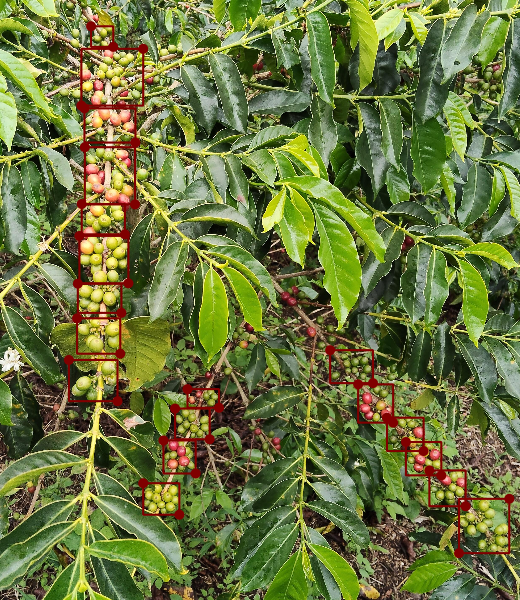

Se genera el dataset en formato YOLO a partir de las imagenes etiquetadas con labelme

In [7]:
!labelme2yolo --val_size 0.2 --test_size 0.1 --output_format bbox --json_dir ../data/labeled/clusters

[2025-05-23T20:23:07Z INFO  labelme2yolo] Starting the conversion process...
[2025-05-23T20:23:07Z INFO  labelme2yolo] Read and parsed 20 JSON files.
⠁ [Train] [00:00:00] [########################################] 14/14 (0s)
  [Train] [00:00:00] [########################################] 14/14 (0s)
⠁ [Val] [00:00:00] [########################################] 4/4 (0s)
  [Val] [00:00:00] [########################################] 4/4 (0s)
⠁ [Test] [00:00:00] [########################################] 2/2 (0s)
  [Test] [00:00:00] [########################################] 2/2 (0s)
[2025-05-23T20:23:07Z INFO  labelme2yolo] Creating dataset.yaml file...
[2025-05-23T20:23:07Z INFO  labelme2yolo] Conversion process completed successfully.


Se reentrena el modelo `yolov8l`, primero hacemos grid search para encontrar la mejor combinación de hiperparametros.

In [ ]:
from ultralytics import YOLO
import itertools
import csv

params_grid = {
    "batch": [2, 4],
    "imgsz": [640, 800],
    "freeze": [0, 10],
    "lr0": [0.001, 0.01],
    "optimizer": ["SGD", "Adam"]
}

param_combinations = list(itertools.product(*params_grid.values()))
results = []

# Grid search
for i, combo in enumerate(param_combinations):
    params = dict(zip(params_grid.keys(), combo))
    name = f"clusters_tuning_run_{i}"
    print(f"\nEntrenando {name} con parámetros: {params}")
    
    model = YOLO("yolov8l.pt")
    model.train(
        data="../data/labeled/clusters/YOLODataset/dataset.yaml",
        epochs=20,  # pocas epocas para tuning
        name=name,
        patience=5,
        **params
    )
    
    metrics = model.val()
    map50 = metrics.box.ap50
    results.append((name, map50, params))

# Guardar en CSV
with open("tuning_results.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["run_name", "map50", "params"])
    for row in results:
        writer.writerow(row)

# Elegir el mejor
best_run = max(results, key=lambda x: x[1])
best_name, best_map, best_params = best_run
print(f"\nMejor modelo: {best_name} con mAP50 = {best_map}")

best_model_path = f"runs/detect/{best_name}/weights/best.pt"

Se entrena el mejor modelo del grid search por 150 epocas

In [ ]:
model = YOLO(best_model_path)
model.train(
    data="../data/labeled/clusters/YOLODataset/dataset.yaml",
    epochs=150,
    name="clusters_best_model",
    **best_params
)

Veamos como se comporta el modelo sobre las imágenes de test

In [14]:
import os

test_img_folder = "../data/labeled/clusters/YOLODataset/images/test"
test_label_folder = "../data/labeled/clusters/YOLODataset/labels/test"
model = YOLO(best_model_path)

def read_labels(label_path):
    labels = []
    with open(label_path, "r") as f:
        for line in f.readlines():
            labels.append(line.strip().split())
    return labels
    
def draw_boxes(image, labels, color):
    h, w, _ = image.shape
    for label in labels:
        class_id, x, y, width, height = map(float, label)
        x, y, width, height = int(x * w), int(y * h), int(width * w), int(height * h)
        cv2.rectangle(image, (x, y), (x + width, y + height), color, 2)
    return image

for img_name in os.listdir(test_img_folder):
    img_path = os.path.join(test_img_folder, img_name)
    label_path = os.path.join(test_label_folder, img_name.replace(".jpg", ".txt")) 
    
    img = cv2.imread(img_path)

    results = model(img_path)
    pred_labels = [[str(obj.cls), *obj.xywh.tolist()] for obj in results[0].boxes] 
    real_labels = read_labels(label_path)

    img_pred = draw_boxes(img.copy(), pred_labels, (0, 255, 0))  # Verde para predicciones
    img_real = draw_boxes(img.copy(), real_labels, (255, 0, 0))  # Rojo para etiquetas reales

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Predicciones del modelo")
    axes[1].imshow(cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Etiquetas reales")

    for ax in axes:
        ax.axis("off")

    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'runs/detect/yolov8m/weights/best.pt'